In [1]:
# Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from collections import defaultdict
# plt.close('all') # 关闭所有活动的 Matplotlib 图形
# %matplotlib inline
from environment import GridWorld
from algorithms import (
    generate_episode, # Though typically not called directly from notebook
    monte_carlo_prediction,
    td0_prediction,
    td_lambda_forward_view,
    td_lambda_backward_view
)
from visualization import (
    plot_value_function_convergence,
    visualize_value_function,
    visualize_eligibility_traces,
    plot_parameter_sensitivity
)

# Configure matplotlib for inline plotting (standard in Jupyter)
# %matplotlib inline # This line is for Jupyter notebooks directly
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

print("Imports successful.")

Imports successful.


In [2]:
# In[2]: Cell 2: Environment Initialization
GRID_SIZE = 5
# Define trap locations, goal, and obstacles
# traps_pos = [(1, 1), (2, 3), (3,0)] # Default from environment
# goal_pos = (GRID_SIZE - 1, GRID_SIZE - 1) # Default
# obstacles_pos = [(0,1), (1,3), (3,3)] # Example custom obstacles

# Initialize environment with default settings or custom ones
# env = GridWorld(size=GRID_SIZE, obstacles=obstacles_pos)
env = GridWorld(size=GRID_SIZE) # Using default traps, goal, and no fixed obstacles initially
# env = GridWorld(size=GRID_SIZE, random_obstacles=True, num_random_obstacles=3)


print("GridWorld Environment:")
env.render() # Render is a simple text print; for graphical, other tools would be needed
print(f"Goal: {env.goal_pos}, Traps: {env.traps_pos}, Obstacles: {env.obstacles_pos}")

# Get all state indices that are not obstacles and not terminal
# These are the states for which we want to learn the value function
# and calculate RMSE.
def get_relevant_state_indices(environment):
    indices = []
    for r_idx in range(environment.size):
        for c_idx in range(environment.size):
            if not environment.is_obstacle(r_idx, c_idx) and \
               not environment.is_terminal_state[(r_idx, c_idx)]:
                indices.append(environment.get_state_index((r_idx, c_idx)))
    return indices

relevant_state_indices = get_relevant_state_indices(env)
print(f"\nNumber of relevant (non-terminal, non-obstacle) states: {len(relevant_state_indices)}")
if not relevant_state_indices:
    print("Warning: No relevant states found. Check obstacle and terminal state definitions.")
    # For example, if start state (0,0) is terminal or obstacle, this list might be empty.
    # Ensure (0,0) is a normal state.
else:
    print(f"Sample relevant state indices: {relevant_state_indices[:5]}")

GridWorld Environment:
A _ _ _ _
_ X _ _ _
_ _ _ X _
X _ _ _ _
_ _ _ _ G
---------
Goal: (4, 4), Traps: [(1, 1), (2, 3), (3, 0)], Obstacles: []

Number of relevant (non-terminal, non-obstacle) states: 21
Sample relevant state indices: [0, 1, 2, 3, 4]


In [3]:
# In[3]: Cell 3: Experiment Parameters
NUM_EPISODES_DEFAULT = 2000 # Number of episodes for most runs
NUM_EPISODES_LONG_RUN = 20000 # For generating a reference V*
GAMMA = 0.99                # Discount factor
ALPHA_TD = 0.1              # Learning rate for TD methods
ALPHA_TD_LAMBDA = 0.1       # Learning rate for TD(lambda)
LAMBDA_VALS = [0.0, 0.5, 0.9, 1.0] # Lambda values to test (0.9 instead of just 1 for smoother TD(lambda) effect)

# Store results
all_V_histories = {}
all_final_V = {}
all_exec_times = {}
all_E_histories = {} # For backward TD(lambda) eligibility trace visualization

print(f"Default number of episodes: {NUM_EPISODES_DEFAULT}")
print(f"Gamma: {GAMMA}, Default Alpha: {ALPHA_TD}")
print(f"Lambda values to test: {LAMBDA_VALS}")

Default number of episodes: 2000
Gamma: 0.99, Default Alpha: 0.1
Lambda values to test: [0.0, 0.5, 0.9, 1.0]



Generating reference V_pi using Every-Visit MC with 20000 episodes...
Reference V_pi generation took 0.58 seconds.


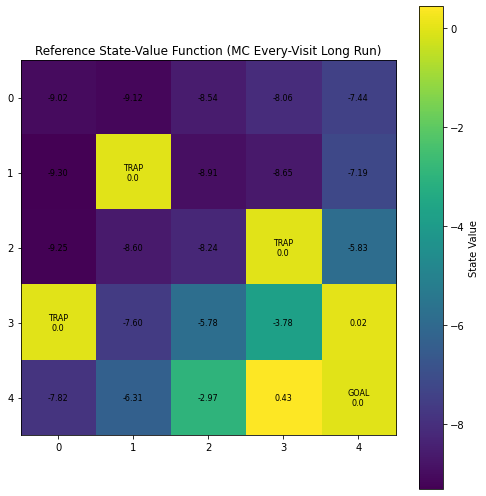

In [4]:
# In[4]: Cell 4: Generate Reference Value Function (V_pi_star_estimate)
# We use a long run of Every-Visit Monte Carlo to get a stable estimate of V_pi
# or implement Iterative Policy Evaluation (not done here for simplicity of model-free focus)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print(f"\nGenerating reference V_pi using Every-Visit MC with {NUM_EPISODES_LONG_RUN} episodes...")
start_time = time.time()
V_pi_star_estimate, _ = monte_carlo_prediction(env,
                                               num_episodes=NUM_EPISODES_LONG_RUN,
                                               gamma=GAMMA,
                                               mode='every-visit')
end_time = time.time()
print(f"Reference V_pi generation took {end_time - start_time:.2f} seconds.")

# Visualize the reference value function
visualize_value_function(V_pi_star_estimate, env, title="Reference State-Value Function (MC Every-Visit Long Run)")



Running MC First-Visit for 2000 episodes...
MC First-Visit took 0.07 seconds.


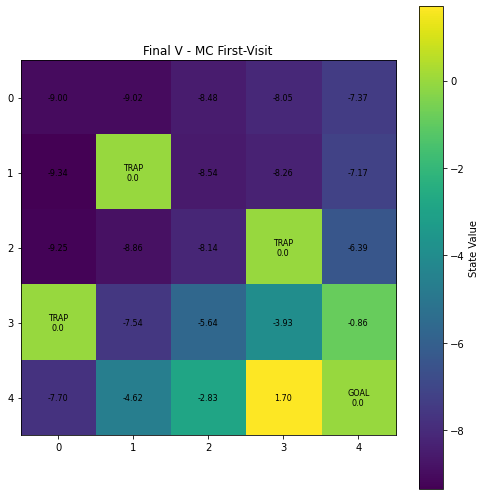


Running MC Every-Visit for 2000 episodes...
MC Every-Visit took 0.06 seconds.


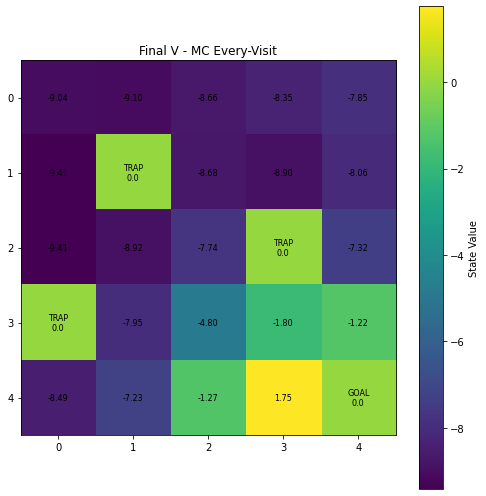

In [5]:
# In[5]: Cell 5: Run Monte Carlo (MC) Prediction Algorithms

# --- First-Visit MC ---
algo_name_mc_fv = "MC First-Visit"
print(f"\nRunning {algo_name_mc_fv} for {NUM_EPISODES_DEFAULT} episodes...")
start_time = time.time()
V_mc_fv, V_hist_mc_fv = monte_carlo_prediction(env,
                                               num_episodes=NUM_EPISODES_DEFAULT,
                                               gamma=GAMMA,
                                               mode='first-visit')
end_time = time.time()
all_final_V[algo_name_mc_fv] = V_mc_fv
all_V_histories[algo_name_mc_fv] = V_hist_mc_fv
all_exec_times[algo_name_mc_fv] = end_time - start_time
print(f"{algo_name_mc_fv} took {all_exec_times[algo_name_mc_fv]:.2f} seconds.")
visualize_value_function(V_mc_fv, env, title=f"Final V - {algo_name_mc_fv}")

# --- Every-Visit MC ---
algo_name_mc_ev = "MC Every-Visit"
print(f"\nRunning {algo_name_mc_ev} for {NUM_EPISODES_DEFAULT} episodes...")
start_time = time.time()
V_mc_ev, V_hist_mc_ev = monte_carlo_prediction(env,
                                               num_episodes=NUM_EPISODES_DEFAULT,
                                               gamma=GAMMA,
                                               mode='every-visit')
end_time = time.time()
all_final_V[algo_name_mc_ev] = V_mc_ev
all_V_histories[algo_name_mc_ev] = V_hist_mc_ev
all_exec_times[algo_name_mc_ev] = end_time - start_time
print(f"{algo_name_mc_ev} took {all_exec_times[algo_name_mc_ev]:.2f} seconds.")
visualize_value_function(V_mc_ev, env, title=f"Final V - {algo_name_mc_ev}")


Running TD(0) (alpha=0.1) for 2000 episodes...
TD(0) (alpha=0.1) took 0.06 seconds.


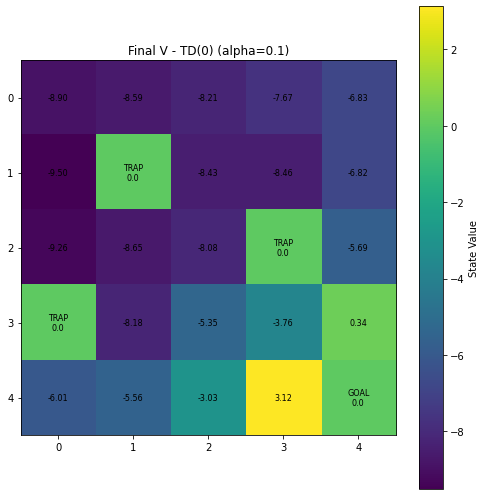

In [6]:
# In[6]: Cell 6: Run Temporal Difference (TD(0)) Prediction

algo_name_td0 = f"TD(0) (alpha={ALPHA_TD})"
print(f"\nRunning {algo_name_td0} for {NUM_EPISODES_DEFAULT} episodes...")
start_time = time.time()
V_td0, V_hist_td0 = td0_prediction(env,
                                   num_episodes=NUM_EPISODES_DEFAULT,
                                   alpha=ALPHA_TD,
                                   gamma=GAMMA)
end_time = time.time()
all_final_V[algo_name_td0] = V_td0
all_V_histories[algo_name_td0] = V_hist_td0
all_exec_times[algo_name_td0] = end_time - start_time
print(f"{algo_name_td0} took {all_exec_times[algo_name_td0]:.2f} seconds.")
visualize_value_function(V_td0, env, title=f"Final V - {algo_name_td0}")


Running Forward TD(lambda=0.0, alpha=0.1) for 2000 episodes...
Forward TD(lambda=0.0, alpha=0.1) took 0.87 seconds.


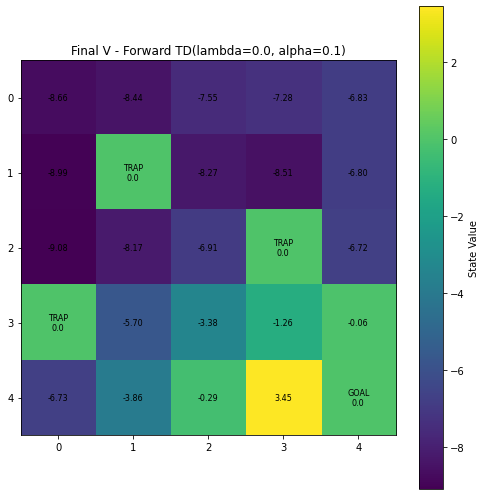


Running Forward TD(lambda=0.5, alpha=0.1) for 2000 episodes...
Forward TD(lambda=0.5, alpha=0.1) took 0.80 seconds.


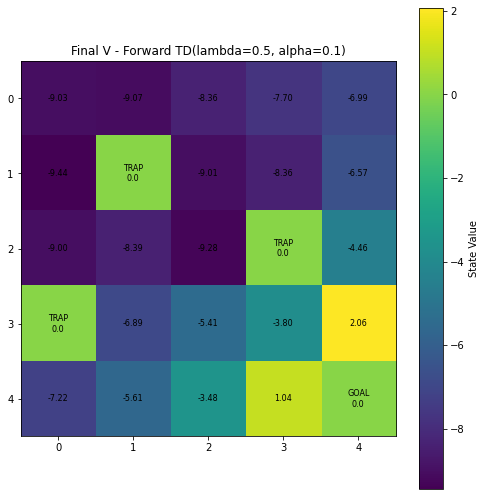


Running Forward TD(lambda=0.9, alpha=0.1) for 2000 episodes...
Forward TD(lambda=0.9, alpha=0.1) took 0.82 seconds.

Running Forward TD(lambda=1.0, alpha=0.1) for 2000 episodes...
Forward TD(lambda=1.0, alpha=0.1) took 0.11 seconds.


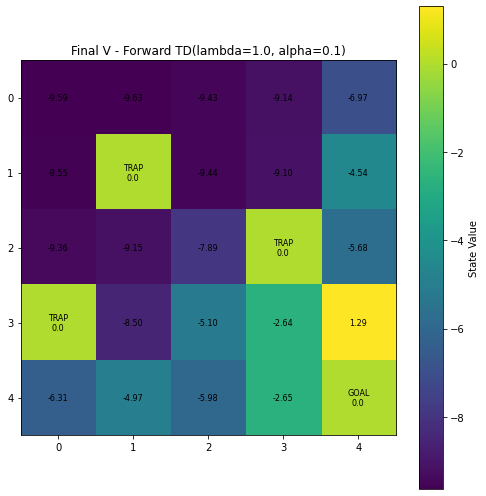

In [7]:
# In[7]: Cell 7: Run Forward View TD(lambda) Prediction

for lmbda in LAMBDA_VALS:
    algo_name_fwd_tdl = f"Forward TD(lambda={lmbda}, alpha={ALPHA_TD_LAMBDA})"
    print(f"\nRunning {algo_name_fwd_tdl} for {NUM_EPISODES_DEFAULT} episodes...")
    start_time = time.time()
    V_fwd_tdl, V_hist_fwd_tdl = td_lambda_forward_view(env,
                                                      num_episodes=NUM_EPISODES_DEFAULT,
                                                      alpha=ALPHA_TD_LAMBDA,
                                                      lambda_param=lmbda,
                                                      gamma=GAMMA)
    end_time = time.time()
    all_final_V[algo_name_fwd_tdl] = V_fwd_tdl
    all_V_histories[algo_name_fwd_tdl] = V_hist_fwd_tdl
    all_exec_times[algo_name_fwd_tdl] = end_time - start_time
    print(f"{algo_name_fwd_tdl} took {all_exec_times[algo_name_fwd_tdl]:.2f} seconds.")
    if lmbda in [0.0, 0.5, 1.0]: # Only visualize for key lambdas to avoid too many plots
         visualize_value_function(V_fwd_tdl, env, title=f"Final V - {algo_name_fwd_tdl}")


Running Backward TD(lambda=0.0, alpha=0.1, replacing) for 2000 episodes...
Backward TD(lambda=0.0, alpha=0.1, replacing) took 0.08 seconds.


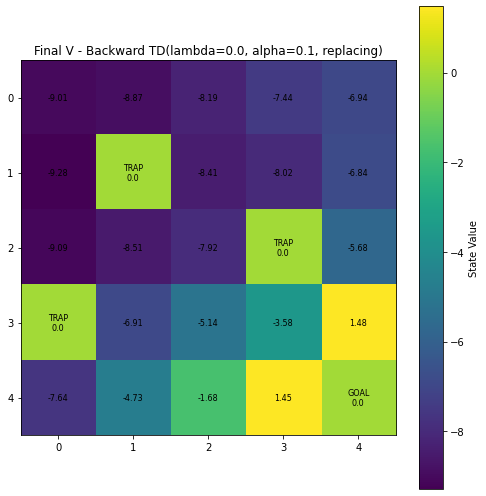


Running Backward TD(lambda=0.5, alpha=0.1, replacing) for 2000 episodes...
Backward TD(lambda=0.5, alpha=0.1, replacing) took 0.13 seconds.


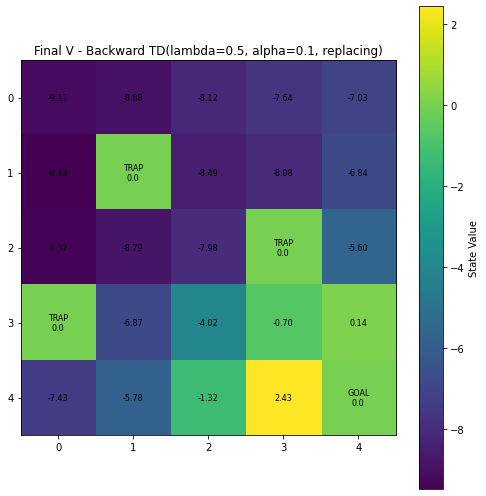


Running Backward TD(lambda=0.9, alpha=0.1, replacing) for 2000 episodes...
Backward TD(lambda=0.9, alpha=0.1, replacing) took 0.12 seconds.

Running Backward TD(lambda=1.0, alpha=0.1, replacing) for 2000 episodes...
Backward TD(lambda=1.0, alpha=0.1, replacing) took 0.11 seconds.


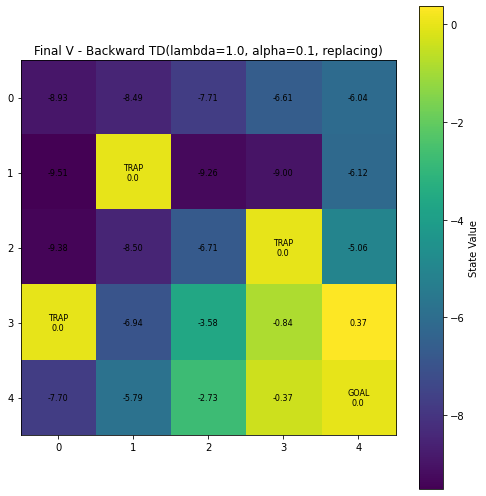

In [8]:
# In[8]: Cell 8: Run Backward View TD(lambda) Prediction (Replacing Traces)

trace_type_bwd = 'replacing' # or 'accumulating'
for lmbda in LAMBDA_VALS:
    algo_name_bwd_tdl = f"Backward TD(lambda={lmbda}, alpha={ALPHA_TD_LAMBDA}, {trace_type_bwd})"
    print(f"\nRunning {algo_name_bwd_tdl} for {NUM_EPISODES_DEFAULT} episodes...")
    start_time = time.time()
    V_bwd_tdl, V_hist_bwd_tdl, E_hist_bwd_tdl = \
        td_lambda_backward_view(env,
                                num_episodes=NUM_EPISODES_DEFAULT,
                                alpha=ALPHA_TD_LAMBDA,
                                lambda_param=lmbda,
                                gamma=GAMMA,
                                trace_type=trace_type_bwd)
    end_time = time.time()
    all_final_V[algo_name_bwd_tdl] = V_bwd_tdl
    all_V_histories[algo_name_bwd_tdl] = V_hist_bwd_tdl
    all_exec_times[algo_name_bwd_tdl] = end_time - start_time
    all_E_histories[algo_name_bwd_tdl] = E_hist_bwd_tdl # Store E history
    print(f"{algo_name_bwd_tdl} took {all_exec_times[algo_name_bwd_tdl]:.2f} seconds.")
    if lmbda in [0.0, 0.5, 1.0]:
         visualize_value_function(V_bwd_tdl, env, title=f"Final V - {algo_name_bwd_tdl}")



Plotting convergence speeds...


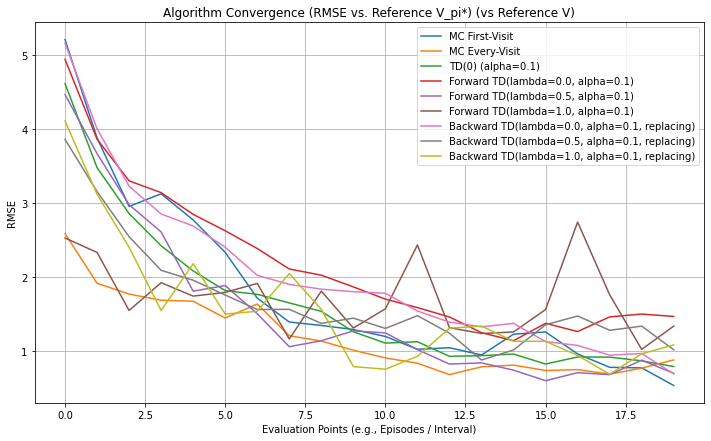

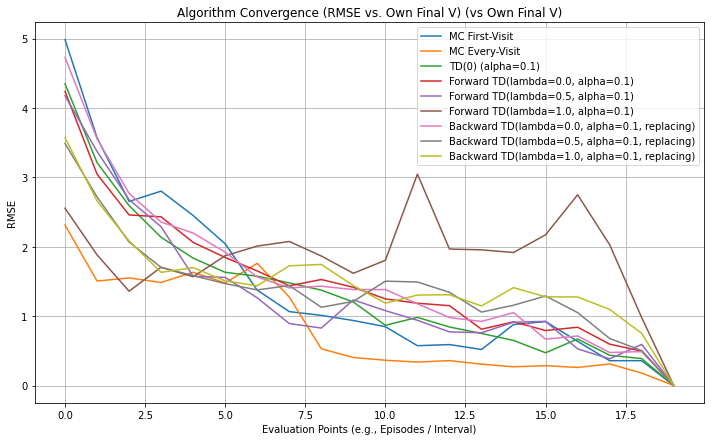

In [9]:
# In[9]: Cell 9: Visualization - Convergence Speed (RMSE vs. Episodes)
print("\nPlotting convergence speeds...")
# Select a subset of algorithms for clarity or plot all
selected_histories_for_plot = {
    k: v for k, v in all_V_histories.items()
    if "lambda=0.9" not in k # Example: exclude lambda=0.9 if too cluttered
}
# Or plot all:
# selected_histories_for_plot = all_V_histories


plot_value_function_convergence(
    V_history_list=list(selected_histories_for_plot.values()),
    labels=list(selected_histories_for_plot.keys()),
    title="Algorithm Convergence (RMSE vs. Reference V_pi*)",
    reference_V=V_pi_star_estimate,
    all_states_indices=relevant_state_indices
)

plot_value_function_convergence(
    V_history_list=list(selected_histories_for_plot.values()),
    labels=list(selected_histories_for_plot.keys()),
    title="Algorithm Convergence (RMSE vs. Own Final V)",
    reference_V=None, # Compares against own final V
    all_states_indices=relevant_state_indices
)



Analyzing TD(0) Alpha sensitivity...
  TD(0) with alpha=0.01, Final RMSE: 4.0810
  TD(0) with alpha=0.05, Final RMSE: 1.3849
  TD(0) with alpha=0.1, Final RMSE: 0.9129
  TD(0) with alpha=0.2, Final RMSE: 1.2157
  TD(0) with alpha=0.3, Final RMSE: 1.2574
  TD(0) with alpha=0.5, Final RMSE: 2.1620


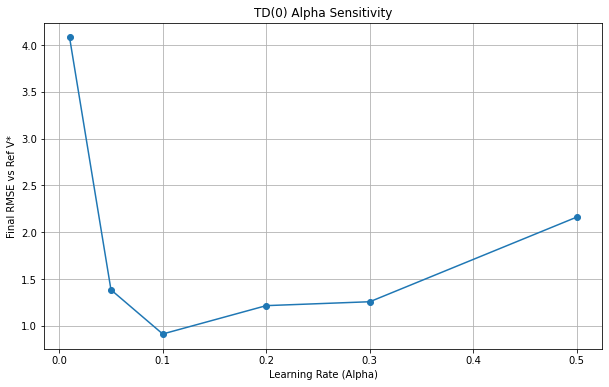

In [10]:
# In[10]: Cell 10: Visualization - Parameter Sensitivity: TD(0) Alpha
print("\nAnalyzing TD(0) Alpha sensitivity...")
alphas_to_test = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
td0_alpha_results = []

for alpha_val in alphas_to_test:
    V_td0_alpha, V_hist_td0_alpha = td0_prediction(env, NUM_EPISODES_DEFAULT, alpha_val, GAMMA)
    # Calculate final RMSE against reference
    squared_errors = []
    for state_idx in relevant_state_indices:
        val_learned = V_td0_alpha.get(state_idx, 0.0)
        val_ref = V_pi_star_estimate.get(state_idx, 0.0)
        squared_errors.append((val_learned - val_ref)**2)
    final_rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else 0
    td0_alpha_results.append((alpha_val, final_rmse))
    print(f"  TD(0) with alpha={alpha_val}, Final RMSE: {final_rmse:.4f}")

plot_parameter_sensitivity(td0_alpha_results, "Learning Rate (Alpha)", "Final RMSE vs Ref V*", "TD(0) Alpha Sensitivity")



Analyzing Forward TD(lambda) Lambda sensitivity...
  Forward TD(lambda=0.0), Final RMSE: 1.4674
  Forward TD(lambda=0.5), Final RMSE: 0.6985
  Forward TD(lambda=0.9), Final RMSE: 0.9471
  Forward TD(lambda=1.0), Final RMSE: 1.3374


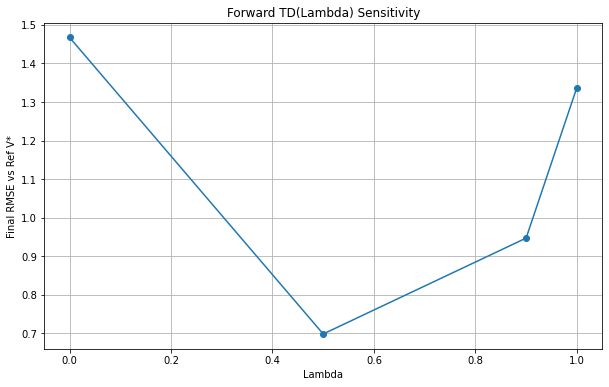


Analyzing Backward TD(lambda) Lambda sensitivity (Replacing Traces)...
  Backward TD(lambda=0.0, replacing), Final RMSE: 0.6918
  Backward TD(lambda=0.5, replacing), Final RMSE: 1.0174
  Backward TD(lambda=0.9, replacing), Final RMSE: 1.2924
  Backward TD(lambda=1.0, replacing), Final RMSE: 1.0821


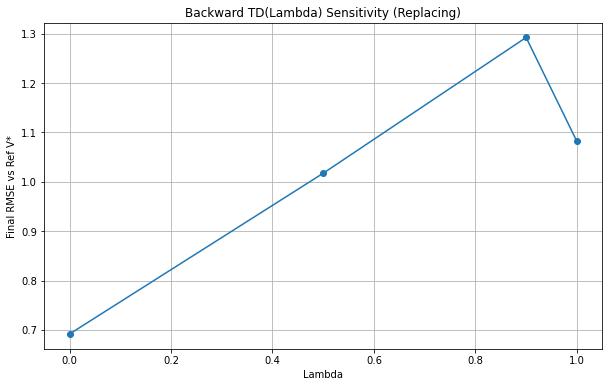

In [11]:
# In[11]: Cell 11: Visualization - Parameter Sensitivity: TD(lambda) - Lambda (Forward View)
print("\nAnalyzing Forward TD(lambda) Lambda sensitivity...")
fwd_td_lambda_rmse_results = []
for lmbda in LAMBDA_VALS: # Using the ones already run
    algo_key = f"Forward TD(lambda={lmbda}, alpha={ALPHA_TD_LAMBDA})"
    if algo_key in all_final_V:
        V_final = all_final_V[algo_key]
        squared_errors = []
        for state_idx in relevant_state_indices:
            val_learned = V_final.get(state_idx, 0.0)
            val_ref = V_pi_star_estimate.get(state_idx, 0.0)
            squared_errors.append((val_learned - val_ref)**2)
        final_rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else 0
        fwd_td_lambda_rmse_results.append((lmbda, final_rmse))
        print(f"  Forward TD(lambda={lmbda}), Final RMSE: {final_rmse:.4f}")

plot_parameter_sensitivity(fwd_td_lambda_rmse_results, "Lambda", "Final RMSE vs Ref V*", "Forward TD(Lambda) Sensitivity")

# (Repeat for Backward View TD(lambda) sensitivity similarly)
print("\nAnalyzing Backward TD(lambda) Lambda sensitivity (Replacing Traces)...")
bwd_td_lambda_rmse_results_replacing = []
for lmbda in LAMBDA_VALS:
    algo_key = f"Backward TD(lambda={lmbda}, alpha={ALPHA_TD_LAMBDA}, replacing)"
    if algo_key in all_final_V:
        V_final = all_final_V[algo_key]
        squared_errors = []
        for state_idx in relevant_state_indices:
            val_learned = V_final.get(state_idx, 0.0)
            val_ref = V_pi_star_estimate.get(state_idx, 0.0)
            squared_errors.append((val_learned - val_ref)**2)
        final_rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else 0
        bwd_td_lambda_rmse_results_replacing.append((lmbda, final_rmse))
        print(f"  Backward TD(lambda={lmbda}, replacing), Final RMSE: {final_rmse:.4f}")

plot_parameter_sensitivity(bwd_td_lambda_rmse_results_replacing, "Lambda", "Final RMSE vs Ref V*", "Backward TD(Lambda) Sensitivity (Replacing)")



Visualizing Eligibility Trace Accumulation for Backward TD(lambda=0.5)...
  Number of steps in last episode for E-trace viz: 12


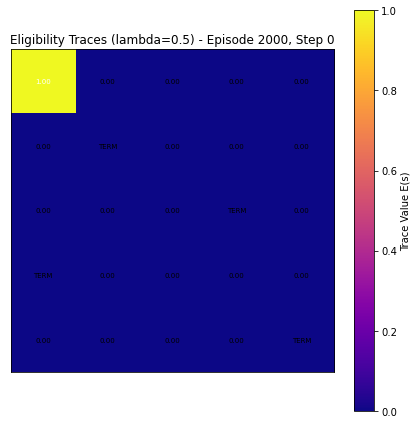

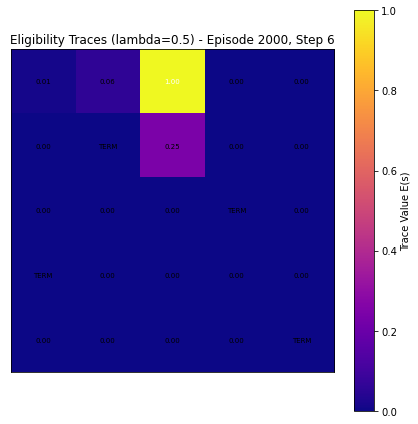

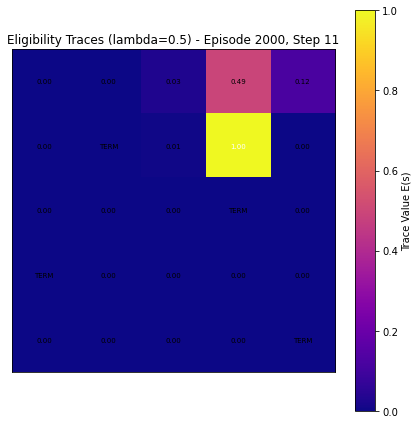

In [12]:
# In[12]: Cell 12: Visualization - Eligibility Trace Accumulation (Backward TD(lambda=0.5))
print("\nVisualizing Eligibility Trace Accumulation for Backward TD(lambda=0.5)...")
target_lambda_for_E_vis = 0.5
algo_key_E_vis = f"Backward TD(lambda={target_lambda_for_E_vis}, alpha={ALPHA_TD_LAMBDA}, {trace_type_bwd})" # Assumes trace_type_bwd is set

if algo_key_E_vis in all_E_histories and all_E_histories[algo_key_E_vis]:
    # Get E history for the last episode for lambda=0.5
    # all_E_histories[algo_key_E_vis] is a list of lists of E_dicts (one list per episode)
    last_episode_E_snapshots = all_E_histories[algo_key_E_vis][-1] # E snapshots from the last episode
    
    if last_episode_E_snapshots:
        print(f"  Number of steps in last episode for E-trace viz: {len(last_episode_E_snapshots)}")
        # Visualize a few key steps (e.g., start, mid, near end)
        steps_to_show = [0, len(last_episode_E_snapshots) // 2, len(last_episode_E_snapshots) - 1]
        if not last_episode_E_snapshots: steps_to_show = []

        for step_idx in steps_to_show:
            if step_idx < len(last_episode_E_snapshots):
                E_snapshot = last_episode_E_snapshots[step_idx]
                visualize_eligibility_traces(E_snapshot, env,
                                             title=f"Eligibility Traces (lambda={target_lambda_for_E_vis})",
                                             episode_num=NUM_EPISODES_DEFAULT, # approx episode num
                                             step_num=step_idx)
    else:
        print(f"  No E-trace snapshots recorded for {algo_key_E_vis} (or last episode was empty).")
else:
    print(f"  E-trace history not found for {algo_key_E_vis} or lambda={target_lambda_for_E_vis}.")



Execution Times (seconds):
  MC First-Visit: 0.070 s
  MC Every-Visit: 0.060 s
  TD(0) (alpha=0.1): 0.062 s
  Forward TD(lambda=0.0, alpha=0.1): 0.870 s
  Forward TD(lambda=0.5, alpha=0.1): 0.804 s
  Forward TD(lambda=0.9, alpha=0.1): 0.824 s
  Forward TD(lambda=1.0, alpha=0.1): 0.107 s
  Backward TD(lambda=0.0, alpha=0.1, replacing): 0.084 s
  Backward TD(lambda=0.5, alpha=0.1, replacing): 0.127 s
  Backward TD(lambda=0.9, alpha=0.1, replacing): 0.116 s
  Backward TD(lambda=1.0, alpha=0.1, replacing): 0.110 s

Comparing final V for Forward vs Backward TD(lambda=0.5)


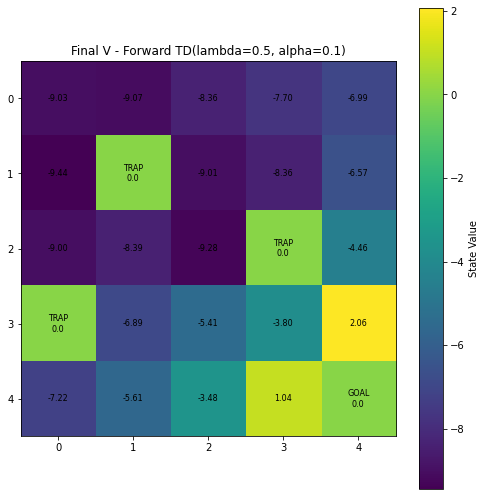

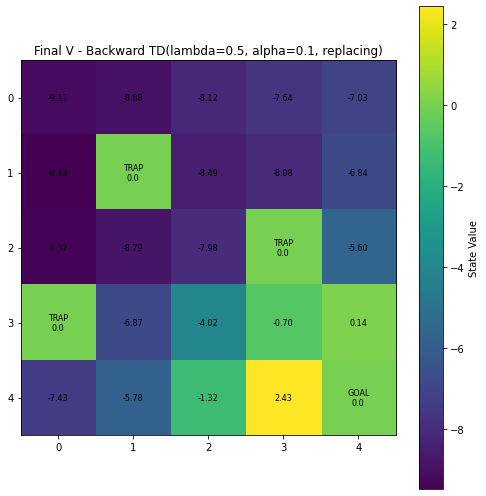

In [13]:
# In[13]: Cell 13: Comparison - Forward vs. Backward TD(lambda)
# - RMSE curves already plotted together.
# - Running Times:
print("\nExecution Times (seconds):")
for name, t_time in all_exec_times.items():
    print(f"  {name}: {t_time:.3f} s")

# - Final Value Function Comparison for a specific lambda (e.g., 0.5)
lambda_compare = 0.5
key_fwd = f"Forward TD(lambda={lambda_compare}, alpha={ALPHA_TD_LAMBDA})"
key_bwd = f"Backward TD(lambda={lambda_compare}, alpha={ALPHA_TD_LAMBDA}, {trace_type_bwd})"

if key_fwd in all_final_V and key_bwd in all_final_V:
    print(f"\nComparing final V for Forward vs Backward TD(lambda={lambda_compare})")
    visualize_value_function(all_final_V[key_fwd], env, title=f"Final V - {key_fwd}")
    visualize_value_function(all_final_V[key_bwd], env, title=f"Final V - {key_bwd}")
else:
    print(f"Could not find results for both Forward and Backward TD(lambda={lambda_compare}) for comparison.")


### Bias-Variance Tradeoff Discussion

* **Monte Carlo (MC) methods:**
    * Estimate $V_\pi(s)$ by averaging returns from state $s$.
    * **Unbiased**: The expected value of the MC estimate is $V_\pi(s)$ (assuming enough samples). The returns are true samples from the policy.
    * **High Variance**: Returns can vary significantly depending on the specific actions taken and subsequent states encountered in an episode. Many episodes are needed to reduce this variance.

* **Temporal Difference (TD) methods (e.g., TD(0)):**
    * Update $V(S_t)$ using $R_{t+1} + \gamma V(S_{t+1})$. This relies on the current estimate $V(S_{t+1})$ (bootstrapping).
    * **Biased**: The TD target $R_{t+1} + \gamma V(S_{t+1})$ is biased because $V(S_{t+1})$ is an estimate, not the true $V_\pi(S_{t+1})$ (especially early in learning).
    * **Lower Variance**: Updates depend only on the next reward and next state's value estimate, not the entire sequence of rewards until the end of the episode. This generally leads to lower variance than MC.

* **TD($\lambda$) methods:**
    * Bridge MC and TD(0).
    * For $\lambda=0$, TD($\lambda$) is similar to TD(0) (biased, lower variance).
    * For $\lambda=1$, TD($\lambda$) is similar to MC (unbiased from data perspective for forward view, higher variance).
    * Intermediate values of $\lambda$ offer a spectrum, often providing a good compromise by controlling the extent of bootstrapping and thus balancing bias and variance. Backward TD($\lambda$) with eligibility traces efficiently implements this.

**(Relate to observed convergence plots: e.g., MC might be noisier but eventually accurate; TD might be smoother but could converge to a slightly biased solution if learning rate/episodes are not optimal. TD(lambda=0.5) might show a good balance.)**



### MC vs. TD Performance with Varying Episode Counts

* **Few Episodes:**
    * MC: Likely to have very high variance. The estimated $V(s)$ can be far from $V_\pi(s)$ due to limited samples of full returns.
    * TD(0): May start to show some structure in the value function more quickly due to lower variance updates and faster propagation of information from rewards (though biased).

* **Many Episodes:**
    * MC: Given enough episodes, the variance reduces, and the estimates converge towards the true $V_\pi(s)$. Convergence can be slow if episodes are long or returns highly variable.
    * TD(0): Also converges, and the bias reduces as $V(s)$ estimates become more accurate. Often converges faster than MC in terms of wall-clock time or number of episodes for practical accuracy, especially in large state spaces.

**(This section could be enhanced by running MC and TD(0) for, say, 100, 1000, 10000 episodes and plotting their final RMSE or visualizing their V-functions at these stages.)**

### Dynamic Lambda Strategies (Optional)

The project mentions potentially trying dynamic $\lambda$ adjustment.
Some ideas:
* **Start with higher $\lambda$ (closer to MC):** Early in learning, when value estimates are poor, relying more on actual returns (less bootstrapping) might be beneficial to reduce the impact of initial bias.
* **Decrease $\lambda$ over time (towards TD(0)):** As value estimates improve, bootstrapping becomes more reliable, and lower $\lambda$ can help reduce variance and speed up fine-tuning.
* **State-dependent $\lambda$:** More complex, might adjust $\lambda$ based on confidence in $V(s)$ or other state features.

A simple approach could be to decay $\lambda$ from a value like 0.9 towards 0.1 over the course of episodes.
Example: $\lambda_{episode} = \lambda_{initial} \times (\text{decay_rate})^{\text{episode_number}}$
Or a linear decay: $\lambda_{episode} = \max(\lambda_{final}, \lambda_{initial} - \text{decay_per_episode} \times \text{episode_number})$

**Analysis:**
* Compare convergence speed and final accuracy of dynamic $\lambda$ against fixed $\lambda$ values.
* It might offer a better bias-variance trade-off adaptively.
* Implementation would require modifying the TD($\lambda$) functions to accept a changing lambda or a schedule.


### Summary & Conclusion

This notebook implemented and compared four model-free prediction algorithms:
1.  Monte Carlo (First-Visit and Every-Visit)
2.  TD(0)
3.  Forward View TD(Lambda)
4.  Backward View TD(Lambda) with Eligibility Traces

In the 5x5 GridWorld environment with a random policy:
* **(Summarize key findings from plots: convergence speed, parameter effects, computational time, final value accuracy for different methods.)**
* **(Discuss which algorithm(s) performed best under what criteria.)**
* **(Reflect on the bias-variance trade-off in practice.)**
* **(Comment on the practical differences between Forward and Backward TD(lambda).)**